# Depth-band plots

Loads depth-frequency-time data and then plots integrated depth-band power for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import numpy as np
for i in range(2):
    %matplotlib notebook

In [19]:
# import data

adcp = 'Axis75'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [20]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)

In [21]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Inertial'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.15e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [5.00e-5,4.00e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

Desired frequency band: Inertial at 1.73e-05 Hz
---
Index at upper freq cutoff: 9
Value at upper freq cutoff: 1.951171875e-05 Hz
---
Index at lower freq cutoff: 7
Value at lower freq cutoff: 1.5175781250000002e-05 Hz
---
Length of new freq array:  3
Upper limit at 1.951171875e-05 Hz
Lower limit at 1.5175781250000002e-05 Hz


## Depth-band PSD spectra

In [22]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [23]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

<IPython.core.display.Javascript object>


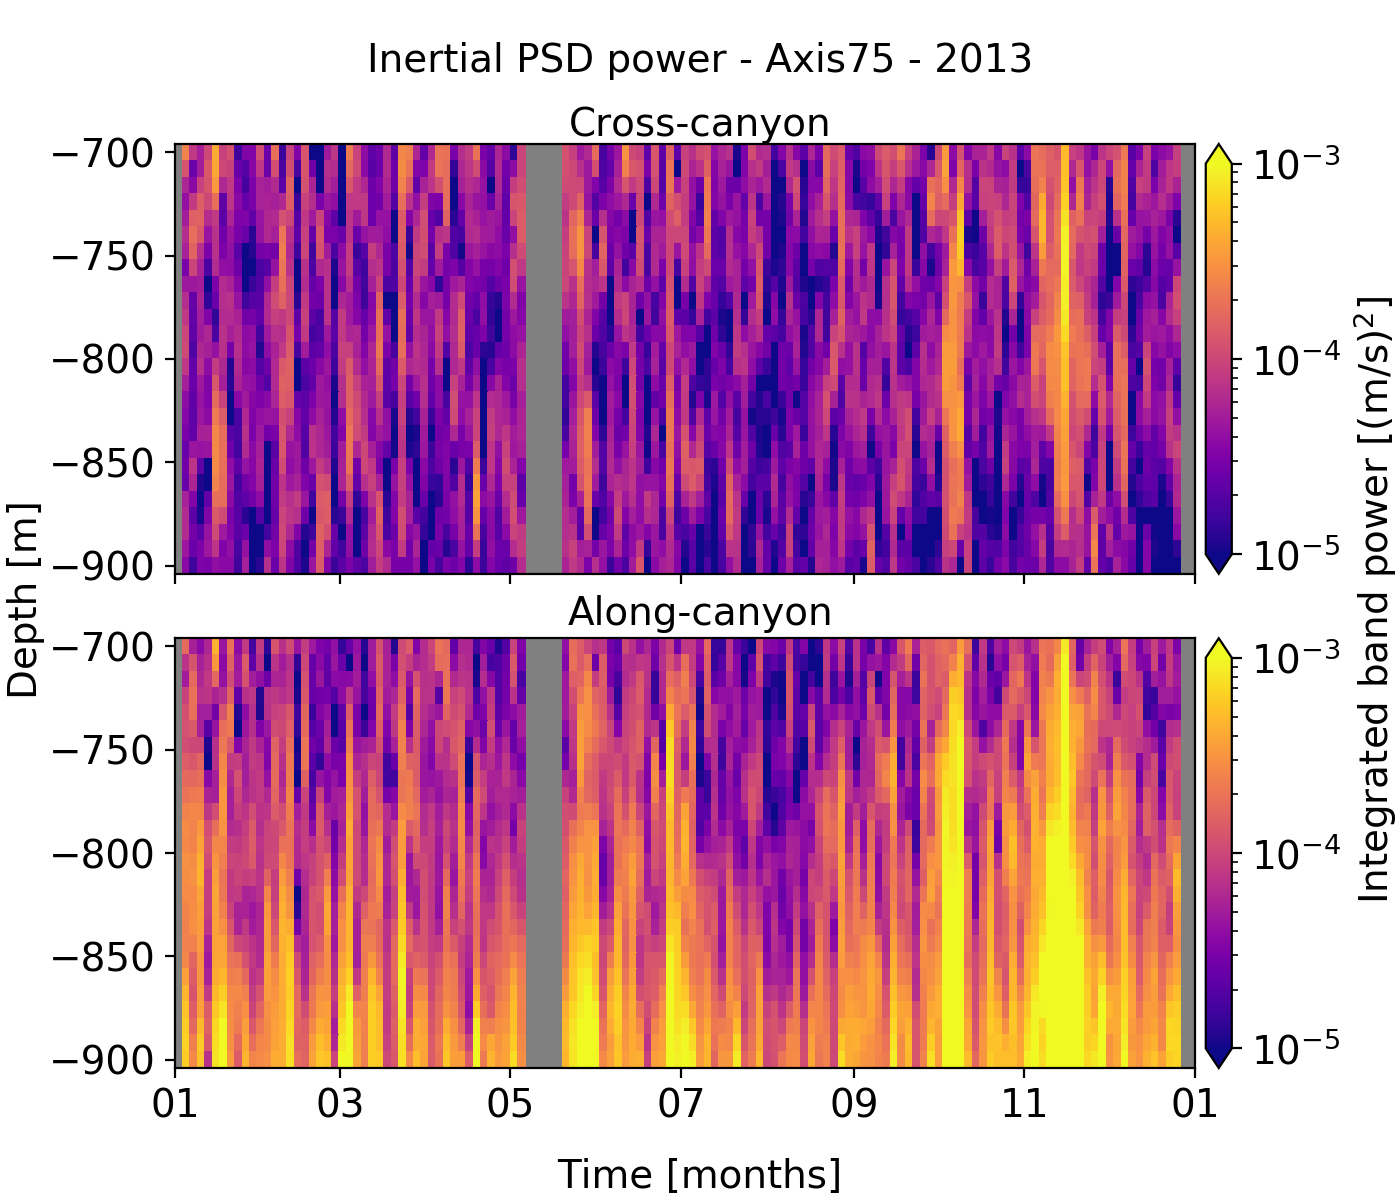

In [24]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} PSD power - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.5, 'Integrated band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 3e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 3e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 3e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 1e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 1e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 2e-4
        vmax = 1e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-5
        vmax = 2e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 2e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-5
        vmax = 2e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  


for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

### Plot w/ barotropic

In [ ]:
# depth-average for each time step

u_PSD_avg, v_PSD_avg = [],[]
for i in range(n_seg):
    ds_temp_u = xr.DataArray(u_WKB[i],dims=('depth','time'))
    ds_temp_v = xr.DataArray(v_WKB[i],dims=('depth','time'))
    u_avg_temp = ds_temp_u.mean(dim='depth')
    v_avg_temp = ds_temp_v.mean(dim='depth')
    u_PSD_avg.append(u_avg_temp - np.mean(u_avg_temp))
    v_PSD_avg.append(v_avg_temp - np.mean(v_avg_temp))

In [ ]:
# plot PSD frequency band power versus depth w/ barotropic time series

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,4),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} PSD power w/ barotropic - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=12)
fig.text(0.95, 0.5, 'Integrated band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=12)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=12)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=12)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        mult = 5e5
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=12)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-4
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=12)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        mult = 5e5
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=12)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=12)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 3e-3
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=12)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=12)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 1e-3
        mult = 1e5
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=12)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=12)

dloc = (depth[-1]+depth[0])/2
for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma') 
    im0bt = ax0.plot(ds[i].spect_s,(u_PSD_avg[i]*mult)-dloc,color='lightcyan',alpha=0.6)
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
    im1bt = ax1.plot(ds[i].spect_s,(v_PSD_avg[i]*mult)-dloc,color='lightcyan',alpha=0.6)

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=12)
cbar1.ax.tick_params(labelsize=12)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.set_ylim(-depth[-1],-depth[0])
ax0.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)

plt.show()

In [ ]:
# check barotropic vs surface tides

dst = xr.open_dataset(f'../Data/tide/tide_{f_name}.nc')

fig,ax = plt.subplots(1,1,figsize=(12,5))

fig.text(0.5, 0.94, f'{f_name} barotropic - Depth-mean ({adcp}) vs surface (Tofino) - {t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)

for i in range(n_seg):
    if i == 0:
        bt = ax.plot(ds[i].spect_s,v_PSD_avg[i]*1e4,label=f'depth-mean ({adcp})',color='tab:blue')
    elif i > 0:
        bt = ax.plot(ds[i].spect_s,v_PSD_avg[i]*1e4,color='tab:blue')
td = ax.plot(dst.time,(dst.tide*10)-np.mean(dst.tide*10),label='surface (Tofino)',color='tab:orange')

date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)
start = np.datetime64('2013-01-01')
end = np.datetime64('2013-12-31')
ax.set_xlim(start,end)
ax.tick_params(labelsize=14)

if f_name == 'Diurnal' and adcp == 'Slope':
    ax.set_ylim(-1,2)
elif f_name == 'Diurnal' and adcp == 'Axis75':
    ax.set_ylim(-4,9)
elif f_name == 'Semidiurnal' and adcp == 'Slope':
    ax.set_ylim(-4,11)
elif f_name == 'Semidiurnal' and adcp == 'Axis75':
    ax.set_ylim(-8,23)

plt.legend()
plt.show()

plt.savefig(fname=f'./archive/tide/tide_{adcp}_{f_name}.pdf',format='pdf')

## Depth-band rotary spectra

In [25]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [26]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

<IPython.core.display.Javascript object>


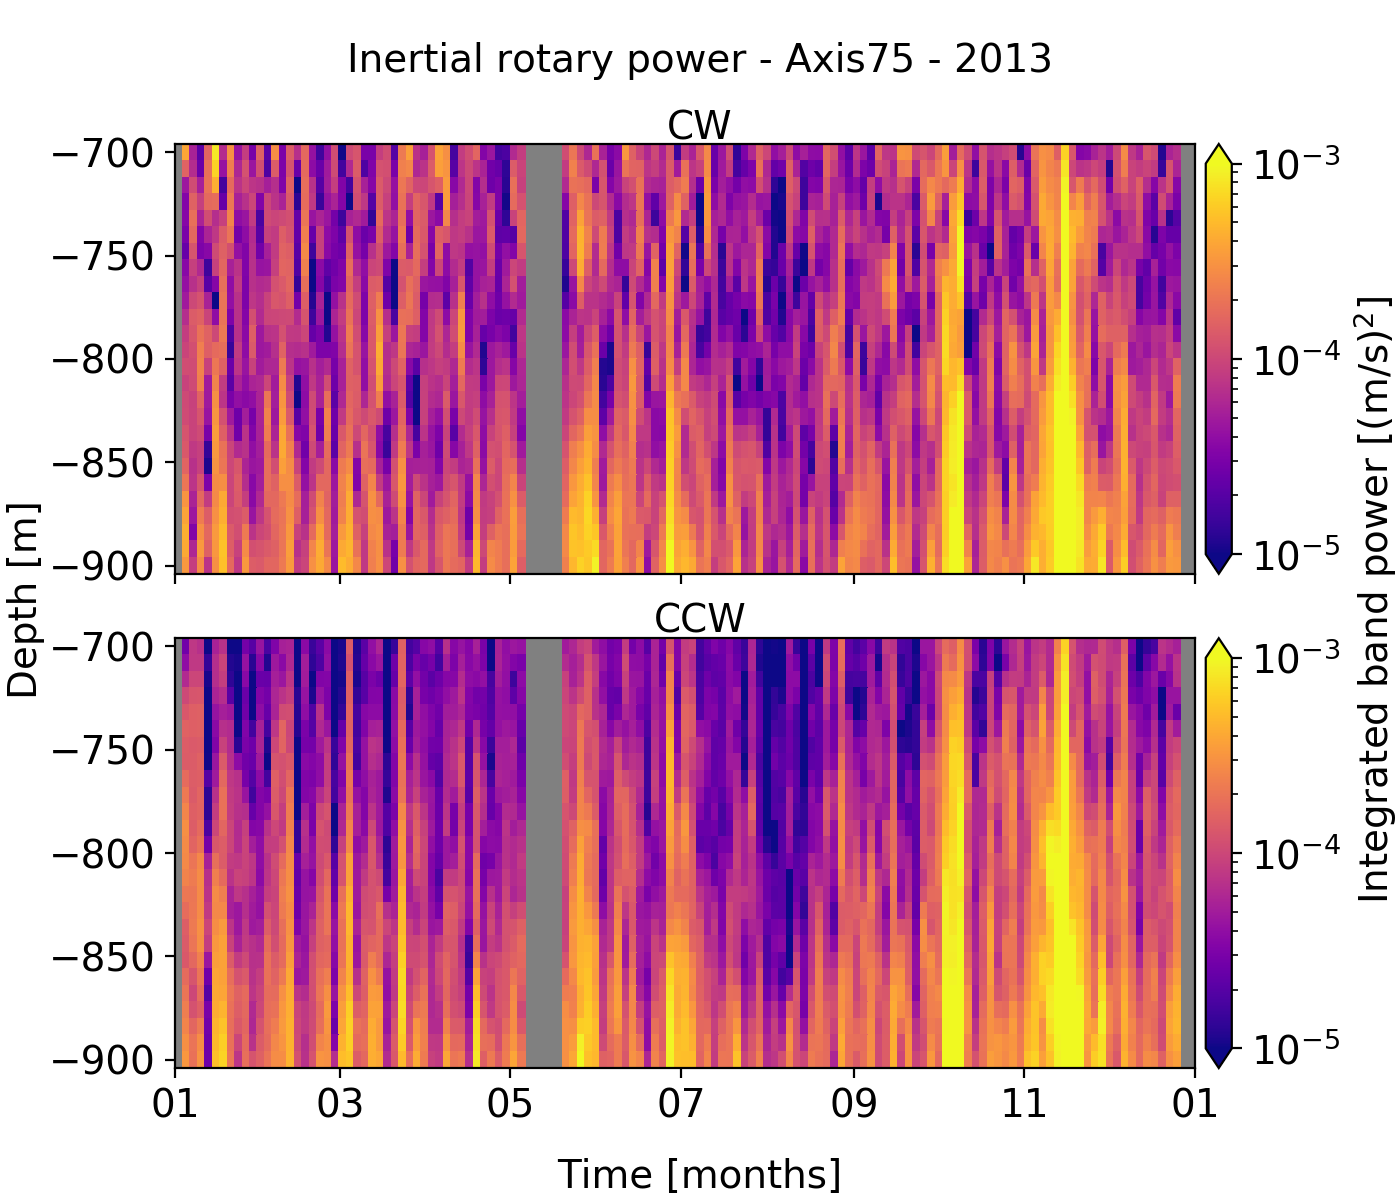

In [27]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} rotary power - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.5, 'Integrated band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 3e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 3e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 3e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 1e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 1e-3
    elif adcp == 'Axis55':
        vmin = 2e-4
        vmax = 1e-3
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-5
        vmax = 2e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 2e-3
    elif adcp == 'Axis55':
        vmin = 1e-5
        vmax = 2e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

### Plot w/ barotropic

In [ ]:
# depth-average for each time step

cw_rot_avg, ccw_rot_avg = [],[]
for i in range(n_seg):
    ds_temp_cw = xr.DataArray(cw_WKB[i],dims=('depth','time'))
    ds_temp_ccw = xr.DataArray(ccw_WKB[i],dims=('depth','time'))
    cw_avg_temp = ds_temp_cw.mean(dim='depth')
    ccw_avg_temp = ds_temp_ccw.mean(dim='depth')
    cw_rot_avg.append(cw_avg_temp - np.mean(cw_avg_temp))
    ccw_rot_avg.append(ccw_avg_temp - np.mean(ccw_avg_temp))

In [ ]:
# plot rotary frequency band power versus depth w/ barotropic

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,4),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} rotary power w/ barotropic - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=12)
fig.text(0.95, 0.5, 'Integrated band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=12)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=12)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 1e-3
        mult = 1e5
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        mult = 5e5
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-4
        mult = 1e5
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        mult = 5e5
        
fig.text(0.5, 0.884, 'CW', ha='center', fontsize=12)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=12)

dloc = (depth[-1]+depth[0])/2
for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
    im0bt = ax0.plot(ds[i].spect_s,(cw_rot_avg[i]*mult)-dloc,color='lightcyan',alpha=0.6)
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  
    im1bt = ax1.plot(ds[i].spect_s,(ccw_rot_avg[i]*mult)-dloc,color='lightcyan',alpha=0.6)
    
cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=12)
cbar1.ax.tick_params(labelsize=12)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.set_ylim(-depth[-1],-depth[0])
ax0.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)

plt.show()